<a href="https://colab.research.google.com/github/haedongmu/AIFFEL_quest_cr/blob/main/MainQuest/Quest04/Main_Quest04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#구글드라이브 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/My Drive/아이펠/archive.zip'


# 2. 압축 파일 경로 설정
extract_to_path = '/content/drive/My Drive/아이펠/archive'


# 3. 압축 해제
import zipfile
import os

os.makedirs(extract_to_path, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Dataset extracted to: {extract_to_path}")

Dataset extracted to: /content/drive/My Drive/아이펠/archive


In [ ]:
!find "/content/drive/My Drive/아이펠/archive/chest_xray" -name '.DS_Store' -delete

/content/drive/My Drive/아이펠/archive
5216
624
16
4185
1047
Normal image path
/content/drive/My Drive/아이펠/archive/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
/content/drive/My Drive/아이펠/archive/chest_xray/chest_xray/train/PNEUMONIA/person610_bacteria_2475.jpeg
Normal images count in training set: 1070
Pneumonia images count in training set: 3115
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  0
624
Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67
Virtual devices cannot be modified after being initialized
Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 126s 376ms/step - accuracy: 0.7357 - loss: 0.4834 - precision: 0.9239 - recall: 0.7010 - val_accuracy: 0.7337 - val_loss: 0.6300 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 76s 292ms/step - accuracy: 0.9014 - loss: 0.2326 - precision: 0.9692 - recall: 0.8973 - val_accuracy: 0.7346 - val_loss: 1.3303 - val_precision: 0.7346 

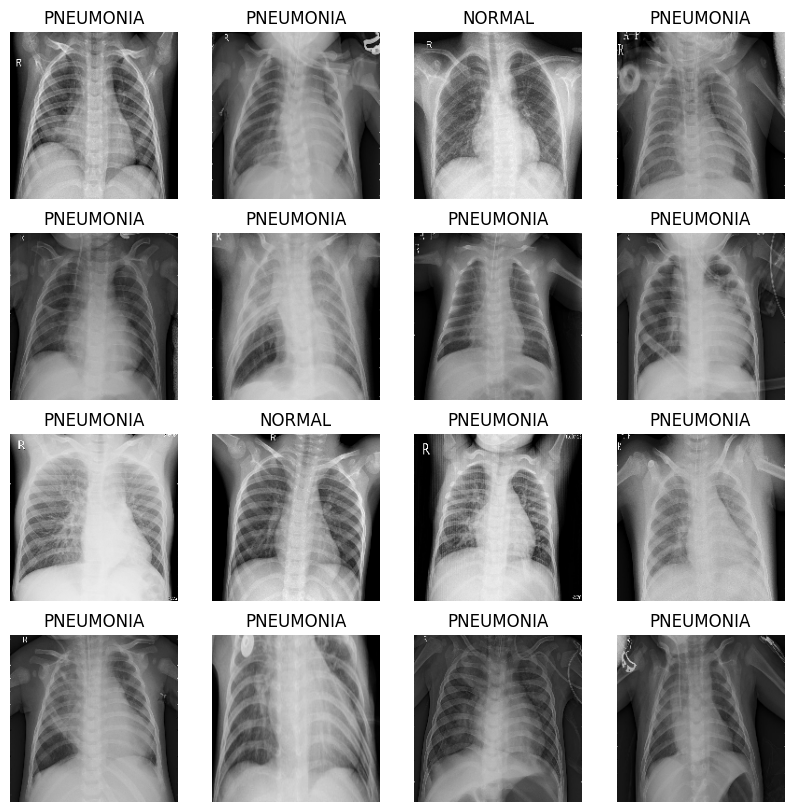

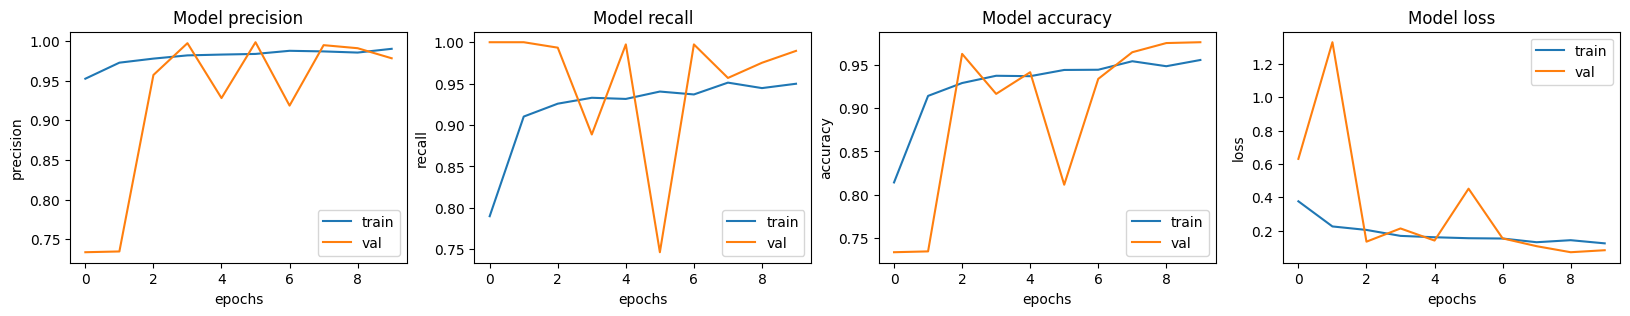

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/content/drive/My Drive/아이펠/archive'
TRAIN_PATH = ROOT_PATH + '/chest_xray/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")


# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    label = tf.cast(label, tf.int32)  # bool -> int32 변환**
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model


weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))


with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # 10GB 제한
        )
    except RuntimeError as e:
        print(e)


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [ ]:
import tensorflow as tf

def residual_block(x, filters, stride=1):
    shortcut = x  # Identity connection

    # 첫 번째 Conv
    x = tf.keras.layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # 두 번째 Conv
    x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Shortcut 연결 (차원이 다르면 Conv로 맞춤)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # Residual 연결
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x


In [ ]:
def build_resnet18(input_shape=(224, 224, 3), num_classes=1000):
    inputs = tf.keras.Input(shape=input_shape)

    # Conv1
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv2_x
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Conv3_x
    x = residual_block(x, filters=128, stride=2)  # 첫 Residual Block에서 다운샘플링
    x = residual_block(x, filters=128)

    # Conv4_x
    x = residual_block(x, filters=256, stride=2)  # 첫 Residual Block에서 다운샘플링
    x = residual_block(x, filters=256)

    # Conv5_x
    x = residual_block(x, filters=512, stride=2)  # 첫 Residual Block에서 다운샘플링
    x = residual_block(x, filters=512)

    # Average Pooling & Fully Connected
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
resnet18 = build_resnet18(input_shape=(224, 224, 3), num_classes=1000)
resnet18.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 112, 112, 64)   │            256 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 56, 56, 64)     │            256 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 56, 56, 64)     │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
│                           │                        │                │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 56, 56, 64)     │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_3[0][0]          │
├──────────────────────

 Total params: 11,703,912 (44.65 MB)

 Trainable params: 11,694,312 (44.61 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]  # 이미지 사이즈
BATCH_SIZE = 16
EPOCHS = 10

# 데이터 경로
ROOT_PATH = '/content/drive/My Drive/아이펠/archive'
TRAIN_PATH = ROOT_PATH + '/chest_xray/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/chest_xray/test/*/*'

# 데이터 파일 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# Train과 Validation 데이터를 결합 후 8:2로 나눔
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# 데이터 전처리 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.int32)

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Residual Block 정의
def residual_block(x, filters, stride=1):
    shortcut = x
    x = tf.keras.layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

# ResNet-18 모델 정의
def build_resnet18(input_shape=(180, 180, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# 클래스 가중치 계산
weight_for_0 = (1 / COUNT_NORMAL) * (len(train_filenames)) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (len(train_filenames)) / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

# 모델 생성 및 컴파일
with tf.device('/GPU:0'):
    model = build_resnet18()
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )

# 모델 훈련
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=len(train_filenames) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=len(val_filenames) // BATCH_SIZE,
        class_weight=class_weight
    )

# 결과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['loss', 'accuracy', 'precision', 'recall']
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label='train')
    ax[i].plot(history.history[f'val_{metric}'], label='val')
    ax[i].set_title(metric)
    ax[i].legend()

# 테스트 데이터 평가
test_ds = tf.data.Dataset.list_files(TEST_PATH).map(process_path).batch(BATCH_SIZE)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')


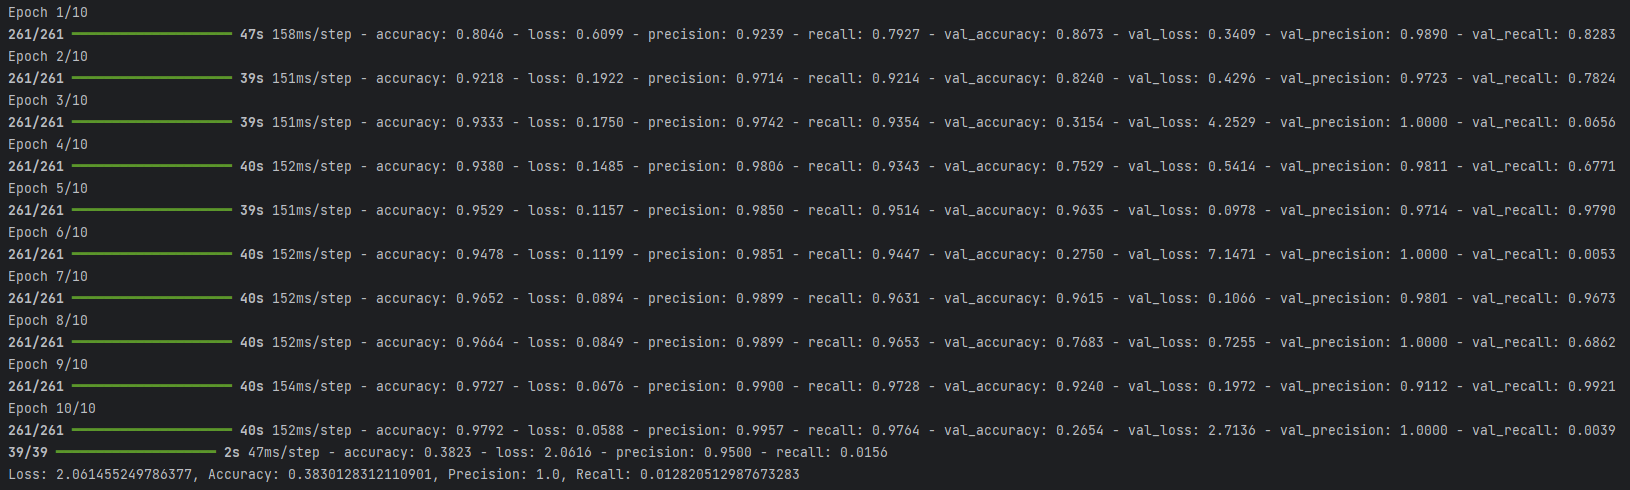

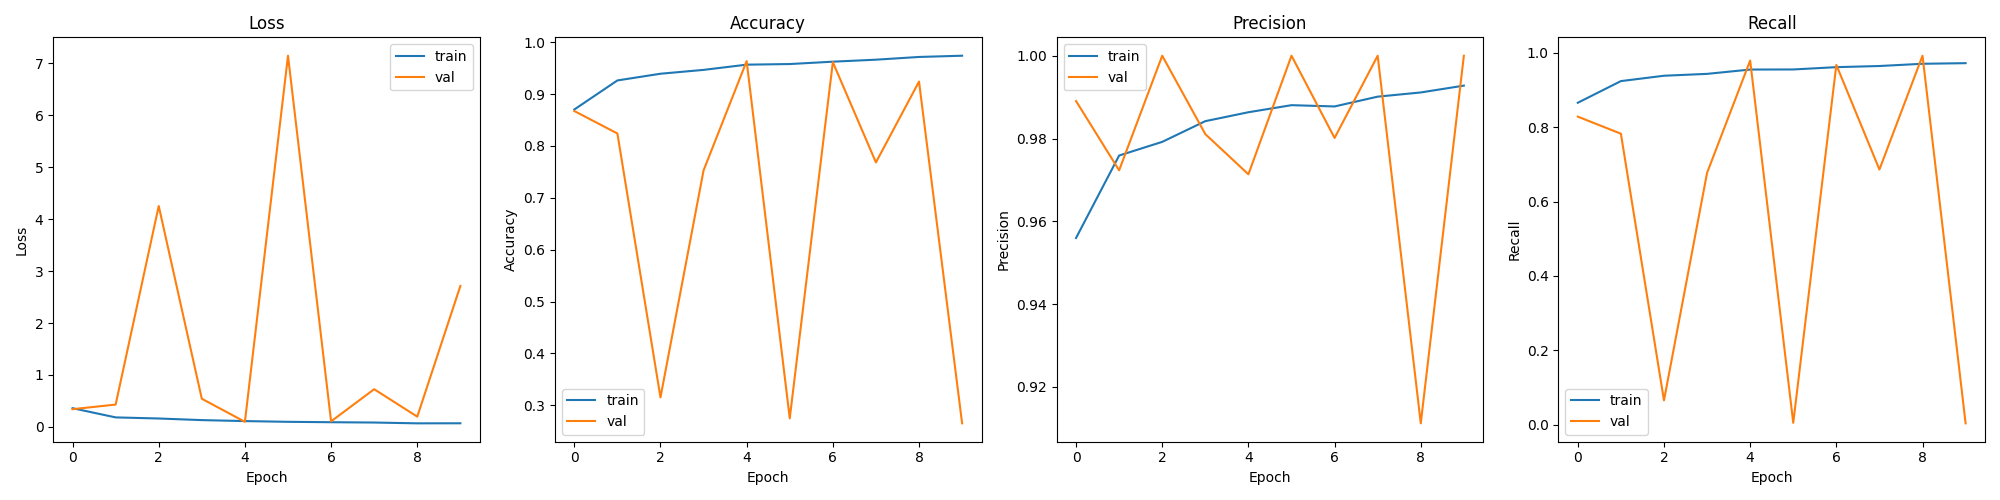

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')

from sklearn.metrics import confusion_matrix, classification_report

# -----------------------
# 1. 설정 파라미터
# -----------------------
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]  # 이미지 사이즈
BATCH_SIZE = 16
EPOCHS = 10

ROOT_PATH = '/content/drive/My Drive/아이펠/archive'
TRAIN_PATH = ROOT_PATH + '/chest_xray/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/chest_xray/test/*/*'

# -----------------------
# 2. 데이터 로드 및 분할
# -----------------------
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)

# train + val 합쳐서 다시 8:2 분할
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("Train data 개수:", len(train_filenames))
print("Val data 개수:", len(val_filenames))
print("Test data 개수:", len(test_filenames))

# -----------------------
# 3. 클래스별 개수 및 class_weight
# -----------------------
COUNT_NORMAL = len([fn for fn in train_filenames if "NORMAL" in fn])
COUNT_PNEUMONIA = len([fn for fn in train_filenames if "PNEUMONIA" in fn])
print("Train - NORMAL:", COUNT_NORMAL, "/ PNEUMONIA:", COUNT_PNEUMONIA)

# 예시) 불균형 완화를 위해 Pneumonia(1)에 조금 더 가중을 줄 수도 있음
weight_for_0 = (1 / COUNT_NORMAL) * (len(train_filenames)) / 2.0  # Normal
weight_for_1 = (1 / COUNT_PNEUMONIA) * (len(train_filenames)) / 2.0  # Pneumonia

# 만약 Recall을 조금 더 강조하고 싶다면 Pneumonia에 추가 가중
weight_for_1 = weight_for_1 * 1.5  # 가중치 배수 조절 (예시)

class_weight = {0: weight_for_0, 1: weight_for_1}
print("Class weight:", class_weight)


# -----------------------
# 4. tf.data 파이프라인 구성
# -----------------------
def get_label(file_path):
    """
    폴더 이름(예: 'PNEUMONIA'/'NORMAL')을 보고 0,1 레이블 반환
    parts[-2]가 정확히 'PNEUMONIA'/'NORMAL' 인지 꼭 확인할 것
    """
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.int32)


def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img


def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


# train, val 리스트 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


def prepare_for_training(ds, shuffle_buffer_size=1000, repeat=True):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    if repeat:
        ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


# train은 repeat, val은 repeat 제거
train_ds = prepare_for_training(train_ds, repeat=True)
val_ds = prepare_for_training(val_ds, repeat=False)
test_ds = test_ds.batch(BATCH_SIZE)


# -----------------------
# 5. ResNet-18 모델 정의
# -----------------------
def residual_block(x, filters, stride=1):
    shortcut = x
    x = tf.keras.layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # shortcut 조정
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x


def build_resnet18(input_shape=(180, 180, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # 초기 레이어
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv2_x
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Conv3_x
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)

    # Conv4_x
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)

    # Conv5_x
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)

    # 출력부
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


# -----------------------
# 6. 모델 생성 및 컴파일
# -----------------------
with tf.device('/GPU:0'):
    model = build_resnet18()
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )

# -----------------------
# 7. 모델 훈련
# -----------------------
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=len(train_filenames) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=len(val_filenames) // BATCH_SIZE,
        class_weight=class_weight  # 클래스 불균형 완화
    )

# -----------------------
# 8. 학습 결과 시각화
# -----------------------
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['loss', 'accuracy', 'precision', 'recall']
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label='train')
    ax[i].plot(history.history[f'val_{metric}'], label='val')
    ax[i].set_title(metric.capitalize())
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric.capitalize())
    ax[i].legend()
plt.tight_layout()
plt.show()

# -----------------------
# 9. 테스트 데이터 평가 + 혼동행렬
# -----------------------
print("\n[Evaluation on Test Set]")
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, "
      f"Precision: {precision:.4f}, Recall: {recall:.4f}")

# (추가) 혼동행렬 및 Classification Report
y_true = []
y_pred = []

# Test 세트 예측 결과 수집
for img_batch, label_batch in test_ds:
    preds = model.predict(img_batch)
    # 기본 threshold=0.5
    preds_binary = (preds >= 0.5).astype(int)
    y_true.extend(label_batch.numpy())
    y_pred.extend(preds_binary)

# 혼동행렬
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 분류 리포트 (Precision, Recall, F1-score 등)
target_names = ['Normal(0)', 'Pneumonia(1)']
report = classification_report(y_true, y_pred, target_names=target_names)
print("\nClassification Report:")
print(report)


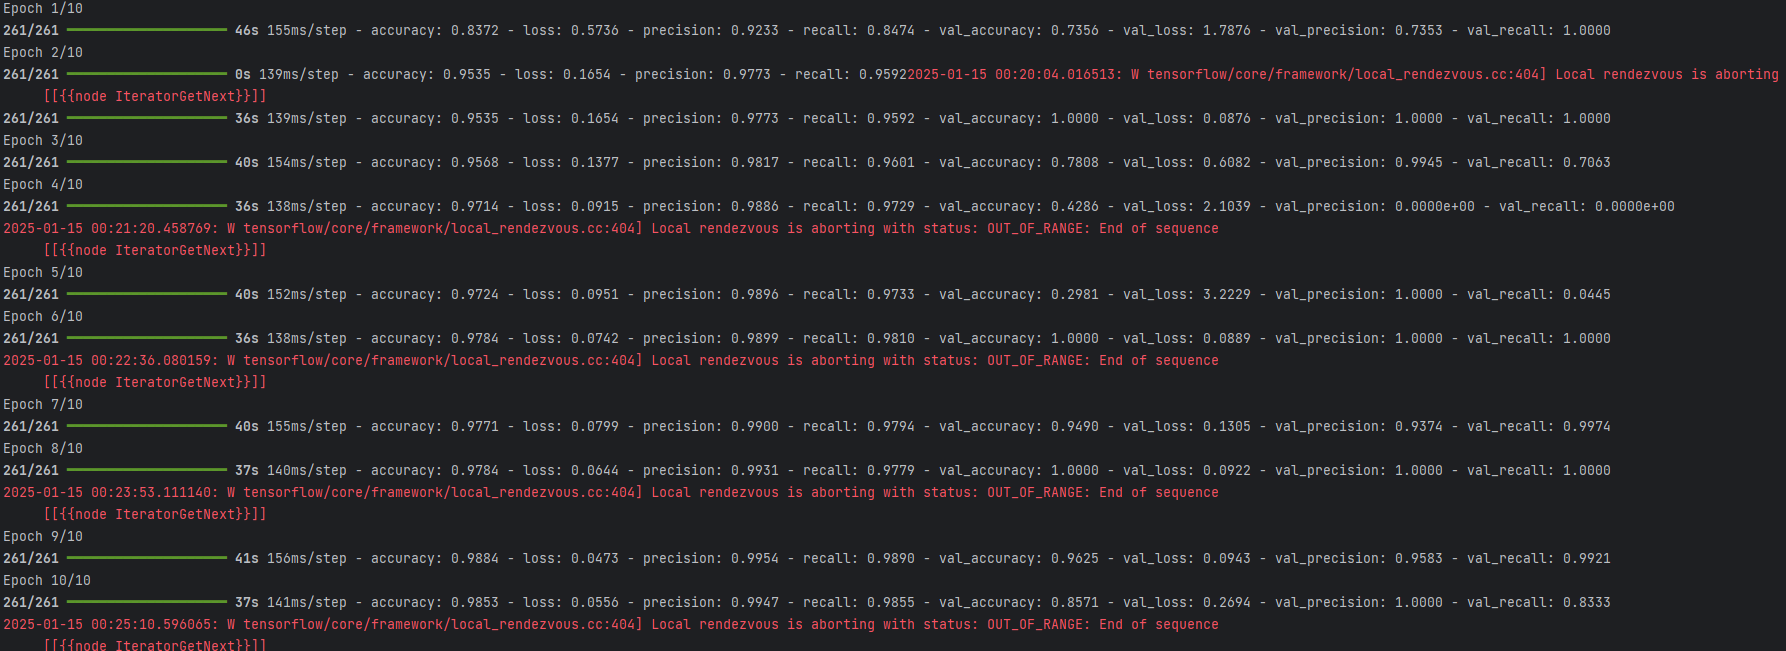

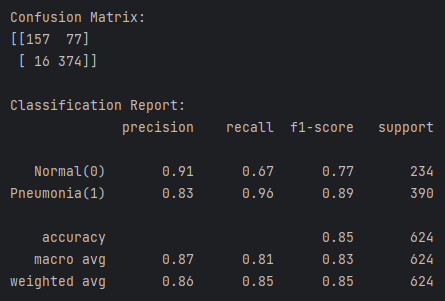

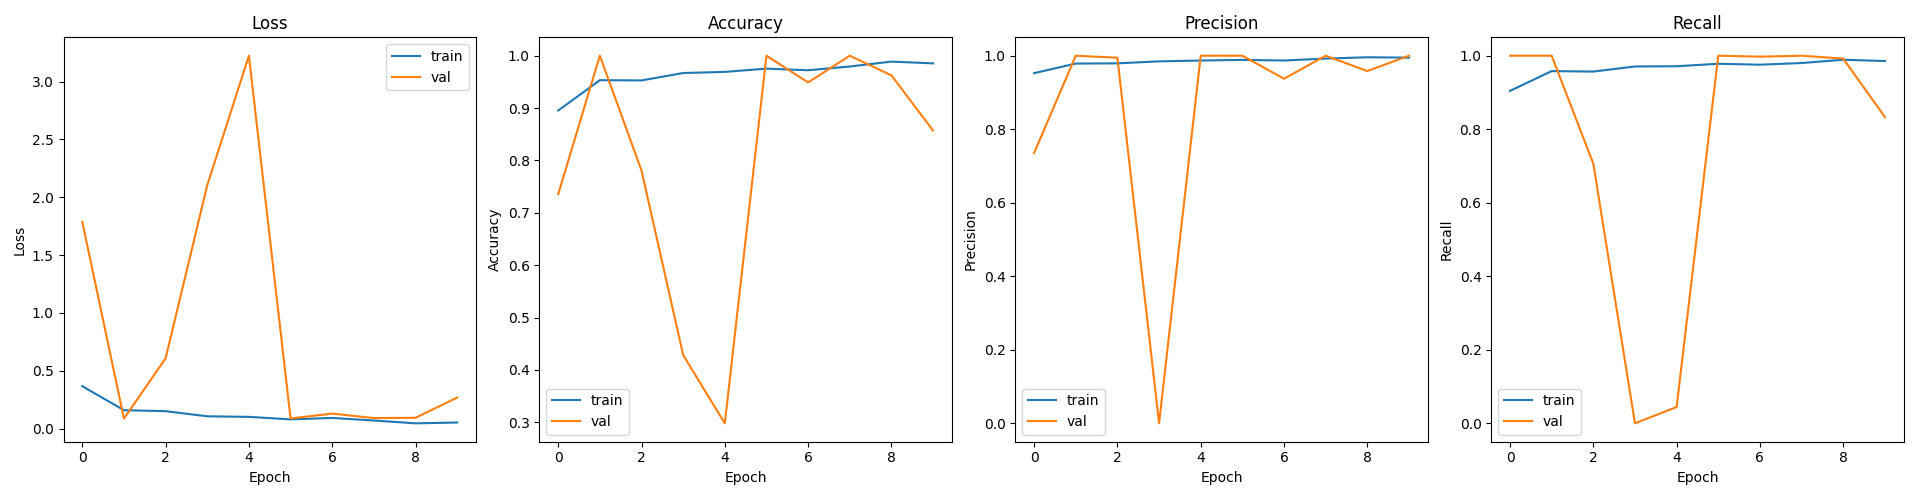

1. 코랩 GPU가 사용량 초과로 정지되었고, 아이펠 쥬피터 노트북은 연결오류가 나서 2번 프로젝트는 제대로 마무리가 되지 못했습니다.

2. 부득이하게 로컬 PC에 파이썬 환경설정하고 코드를 실행시켜 보고 결과값을 이미지로 첨부하였습니다. 로컬 PC는 지포스 4070Ti 를 사용하여 코랩GPU 보다는 실행속도가 2배 정도 빨랐습니다.